Ouvrir ce notebook dans :
<a href="https://colab.research.google.com/github/joanglaunes/deep_learning_image/blob/main/CircleSquare_0.ipynb" target="_blank">Google Colab</a>
ou
<a href="https://rosenblatt.ens.math-info.univ-paris5.fr/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fjoanglaunes%2Fdeep_learning_image&urlpath=tree%2Fdeep_learning_image%2FCircleSquare_0.ipynb&branch=main" target="_blank">Rosenblatt</a>

Exemple de réseau convolutionnel avec PyTorch. On construit des données simples d'images représentant des disques et des carrés puis on entraîne un petit réseau à trois couches pour qu'il distingue les deux classes.

Tout d'abord on importe les librairies PyTorch, NumPy et MatplotLib :

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

Fonction pour créer les données images : la fonction CreateData renvoie un tenseur I de taille Nx1x32x32 contenant les images et un vecteur L contenant les classes (0 ou 1)

In [ ]:
def CreateData(N):
    M = 32
    I = np.zeros([N,1,M,M])
    L = np.zeros(N)
    ech = np.linspace(0,1,M)
    X,Y = np.meshgrid(ech,ech)
    for k in range(N):
        r = 1/8+np.random.rand(1)/8 # random radius
        c = r+(1-2*r)*np.random.rand(2,1) # random center position
        if np.random.rand(1)<.5:
            # circle
            I[k,0,:,:] = ((X-c[0])**2+(Y-c[1])**2) < r**2
            L[k] = 0
        else:
            # square
            I[k,0,:,:] = np.maximum(np.abs(X-c[0]),np.abs(Y-c[1])) < r
            L[k] = 1
    return I, L

On crée 2500 images et on affiche les 5 premières :

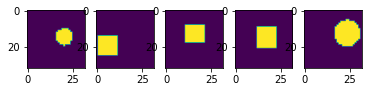

In [ ]:
N = 100
I, L = CreateData(N)
for k in range(5):
    plt.subplot(1, 5, k+1)
    plt.imshow(np.squeeze(I[k,0,:,:]))

plt.show()

On convertit les données en tenseurs PyTorch :

In [ ]:
I = torch.from_numpy(I.astype('float32'))
L = torch.from_numpy(L.astype('long'))

On sépare les données en deux parties : données d'entraînement pour les 90 premières, et données de test pour les 10 dernières :

In [ ]:
Ntest = len(L)-10
Itrain = I[:Ntest,:,:,:]
Ltrain = L[:Ntest]
Itest = I[Ntest:,:,:,:]
Ltest = L[Ntest:]

A présent on définit les variables du réseau : deux filtres de convolution fa et fb et une matrice m. On ajoute requires_grad=True pour indiquer qu'on va avoir besoin de calculer le gradient de la fonction de coût par rapport à ces variables.

In [ ]:
fa = torch.randn(16,1,5,5,requires_grad=True)
fb = torch.randn(32,16,5,5,requires_grad=True)
m = torch.randn(8*8*32,2,requires_grad=True)

On définit maintenant une fonction pour le réseau.
Cette fonction correspond au calcul "forward" du réseau : l'entrée
est supposé être un tenseur I de taille (batch_size,1,32,32), auquel on va appliquer successivement les opérations des différentes couches du réseau.

In [ ]:
def mycnn(I):                                      # input I shape: (N,1,32,32)

    # first layer
    out = F.conv2d(I, fa, padding=2)               # out shape: (N,16,32,32)
    out = nn.BatchNorm2d(16, affine=False)(out)    # out shape: (N,16,32,32)
    out = torch.relu(out)                          # out shape: (N,16,32,32)
    out = F.max_pool2d(out,2,stride=2)             # out shape: (N,16,16,16)

    # second layer
    out = F.conv2d(out, fb, padding=2)             # out shape: (N,32,16,16)
    out = nn.BatchNorm2d(32, affine=False)(out)    # out shape: (N,32,16,16)
    out = torch.relu(out)                          # out shape: (N,32,16,16)
    out = F.max_pool2d(out,2,stride=2)             # out shape: (N,32,8,8)

    # flatten
    out = out.reshape(out.size(0), -1)             # out shape: (N,32*8*8)

    # third layer
    out = out.mm(m)                                # out shape: (N,2)

    return out

On passe à présent à l'entraînement du réseau :

In [ ]:
niter = 100
lossrec = np.zeros(niter)
learning_rate = 1e-2
for t in range(niter):
    out = mycnn(Itrain)
    loss = nn.CrossEntropyLoss()(out,Ltrain)
    lossrec[t] = loss.item()
    print(t,lossrec[t])
    loss.backward()
    fa.data -= learning_rate * fa.grad.data  # fa <- fa - eta * gradient_fa(loss)
    fa.grad.zero_()
    fb.data -= learning_rate * fb.grad.data  # fb <- fb - eta * gradient_fb(loss)
    fb.grad.zero_()
    m.data -= learning_rate * m.grad.data    # m <- m - eta * gradient_m(loss)
    m.grad.zero_()

0 30.527368545532227
1 28.56959342956543
2 26.738861083984375
3 25.08894920349121
4 23.530702590942383
5 22.035707473754883
6 20.602123260498047
7 19.22312355041504
8 17.922061920166016
9 16.724319458007812
10 15.747651100158691
11 14.91407585144043
12 14.087448120117188
13 13.364411354064941
14 12.765649795532227
15 12.231484413146973
16 11.758696556091309
17 11.31386947631836
18 10.891640663146973
19 10.489226341247559
20 10.124588012695312
21 9.77418327331543
22 9.434625625610352
23 9.103911399841309
24 8.784868240356445
25 8.478388786315918
26 8.195160865783691
27 7.927760601043701
28 7.665294647216797
29 7.411813735961914
30 7.168008804321289
31 6.9280266761779785
32 6.698916912078857
33 6.476353645324707
34 6.261178016662598
35 6.039685249328613
36 5.833250045776367
37 5.6365766525268555
38 5.447880744934082
39 5.264623165130615
40 5.090309143066406
41 4.932889461517334
42 4.784624099731445
43 4.641351699829102
44 4.5012383460998535
45 4.359932899475098
46 4.220130920410156
47 4.

On affiche les valeurs de la fonction coût en fonction des itérations :

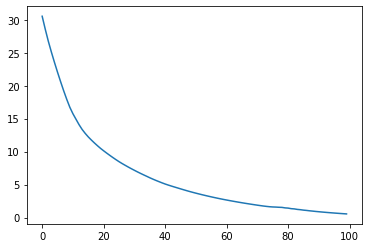

In [ ]:
plt.plot(lossrec)
plt.show()

Le réseau est entraîné ; à présent on évalue les performances, d'abord on calcule le nombre d'erreurs sur les données d'apprentissage ; ensuite sur les données de test :

In [ ]:
values, indices = torch.max(out, 1)
print("taux d'erreur sur données d'apprentissage:",(indices!=Ltrain).float().mean().item())

taux d'erreur sur données d'apprentissage: 0.08888889104127884


In [ ]:
out = mycnn(Itest)
values, indices = torch.max(out, 1)
print("taux d'erreur sur données de test:",(indices!=Ltest).float().mean().item())

taux d'erreur sur données de test: 0.5


On voit ici que le taux d'erreurs sur les données d'apprentissage est assez faible mais beaucoup moins sur les données test. La taille N=100 des données n'est pas suffisante, et surtout l'apprentissage s'est fait toujours sur les mêmes données, ce qui aboutit à du surapprentissage.